In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] ='40'
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt 
import pandas as pd
#import nest 
import struct
import os
import json
import sys
import seaborn as sns 
from scipy import signal, stats

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# **Data**
- Wagenaar data
- burst detection 
- averaged over channels 
- peak aligned and zero padded 

In [3]:
data_dir = "../Data/"

In [4]:
data_burst_by_time = np.load(data_dir + 'data_burst_by_time.npy').T
data_burst_by_time_20_21 = np.load(data_dir + 'raw_Data/data_burst_by_time_20_21.npy').T
data_burst_by_time_shuffled = (np.random.permutation(data_burst_by_time))
print("Averaged over channels (Day 20): ", data_burst_by_time.shape)
print("Averaged over channels (Day 20+21): ", data_burst_by_time_20_21.shape)

Averaged over channels (Day 20):  (13092, 3410)
Averaged over channels (Day 20+21):  (24663, 3410)


In [4]:
dataset_cutted = data_burst_by_time[:,1000:2500] # 1. cut 1000 - 2500 2. cut 1200 - 2200
dataset_cutted2 = data_burst_by_time[:,1200:2200]
print("First Cut: ", dataset_cutted.shape)
print("Second Cut: ", dataset_cutted2.shape)

First Cut:  (13092, 1500)
Second Cut:  (13092, 1000)


# **Splitting the Data into Training and Validation Sets**

## Training and Validation split culterwise 
- dataset ordered by culture
- for each culture randomly put 75% of the burst into the training and 25% into the validation set

In [9]:
def culture_balanced_split(data,culture_counts):
    np.random.seed(6)
    training_split = [] # list containing indices of training bursts
    culture_border = np.sort(np.append(np.cumsum(culture_counts),0)) # get index of bursts belonging to each culture in dataset

    for i,culture_count in enumerate(culture_counts):
        if i+1 < len(culture_border): # still in range of cultures 
            training_split_index = np.random.choice(np.arange(culture_border[i], culture_border[i+1]), int(0.75*culture_count),replace=False) # randomly select 75% of indices within culture_i
            training_split += list(training_split_index) # add 75% of culture_i to training data


    training_split = np.sort(training_split) # sort indices of training bursts   
    validation_split = np.delete(np.arange(0,len(data)), training_split) # rest of the bursts for validation
    
    return training_split, validation_split

In [ ]:
#culture_counts = [141, 531, 128, 194, 1782, 2112, 1656, 554, 235, 661, 143, 142, 2853, 61, 338, 231, 30, 156, 270, 416, 77, 96, 285] # bursts per culture 
#culture_names = ["C11","C12","C15","C21","C22","C23","C24","C25","C26","C31","C32", "C33", "C34","C35","C36", "C51","C52","C53","C71","C72","C81","C82","C83"]

#training_split, validation_split = culture_balanced_split(dataset_cutted2, culture_counts)

#training_set = dataset_cutted2[training_split]  #data_burst_by_time[training_split] # extract training bursts from dataset with indices
#validation_set = dataset_cutted2[validation_split]  #data_burst_by_time[test_split] # extract validation bursts from dataset with indices 

## k-fold split
- split dataset into k folds and build training and validation sets for cross validation

In [5]:
def k_fold_split(data,k_folds = 5): 
    """ Split data into k folds and build training and validation set with ratio 4:1 for all fold combinations 
    
    Args:
        data (nd.array): Array containing data (n x m)
        k_folds (int): Number of folds to split the data
    
    Returns:
        train_folds (list of nd.arrays): list of k training set indices each with dimension n-(n/k) x m
        valid_folds (list of nd.arrays): list of k validation set indices each with dimension n/k x m
    """
    fold_length = int(data.shape[0]/k_folds) #length of each fold
    valid_folds = []
    train_folds = []
    for i in range(k_folds-1):
        valid_folds += [data[i*fold_length:(i+1)*fold_length]] 
        train_folds += [np.delete(data, range(i*fold_length,(i+1)*fold_length), axis = 0)]
      
    valid_folds += [data[(k_folds-1)*fold_length:]]
    train_folds += [np.delete(data, range((k_folds-1)*fold_length, len(data)), axis = 0)]
    return train_folds, valid_folds 

In [11]:
n_total = data_burst_by_time.shape[0] #dataset_cutted2.shape[0] # total number of bursts in data
n_shuffled = np.random.RandomState(seed=42).permutation(n_total) # randomly shuffle data 

train_folds, valid_folds = k_fold_split(n_shuffled, k_folds = 2) # k fold split indices 

for i, fold in enumerate(train_folds):
    print("Fold %d: Training Data: %d Bursts Validation Data: %d Bursts" % ((i+1),len(fold), len(valid_folds[i])))

Fold 1: Training Data: 6546 Bursts Validation Data: 6546 Bursts
Fold 2: Training Data: 6546 Bursts Validation Data: 6546 Bursts


In [12]:
#np.save(data_dir + "train_folds_50_50" , train_folds)
#np.save(data_dir + "valid_folds_50_50" , valid_folds)

## Overlapping Split
- Split the data in 2 sets with overlapping proportion

In [17]:
def overlapping_2_fold_split(data, overlap_proportion = 0.25):
    data = list(data)
    overlap_length = int(len(data) * overlap_proportion)
    overlap = np.random.RandomState(seed=42).choice(data, size=overlap_length, replace=False)
    for i in overlap:
        data.remove(i)
    
    fold_length = int(len(data)/2)
    set1 = list(data[:fold_length]) + list(overlap)
    set2 = list(data[fold_length:]) + list(overlap)
    
    return set1, set2 

In [18]:
n_total = data_burst_by_time.shape[0] #dataset_cutted2.shape[0] # total number of bursts in data
n_shuffled = np.random.RandomState(seed=42).permutation(n_total) # randomly shuffle data 

set1_indices, set2_indices = overlapping_2_fold_split(n_shuffled) 

print("Set 1: %d Bursts, Set2: %d Bursts" % (len(set1_indices), len(set2_indices)))

Set 1: 8182 Bursts, Set2: 8183 Bursts


## Daywise Split 
- Split the data in daywise into 2 sets

In [ ]:
# If items(), keys(), values(),  iteritems(), iterkeys(), and  itervalues() are called with no intervening modifications to the dictionary, the lists will directly correspond.

In [84]:
def day_wise_split(data, training_days,culture_counts):
    days = np.asarray([int(culture_name.split("_")[-1]) for culture_name in list(culture_counts.keys())])
    
    training_split = [] # list containing indices of training bursts
    culture_border = np.sort(np.append(np.cumsum(list(culture_counts.values())),0)) # get index of bursts belonging to each culture in dataset
    
    for day in training_days:
        index_first_culture_of_day = np.where(day == days)[0][0]
        index_last_culture_of_day =  np.where(day == days)[0][-1]
        training_split+=list(np.arange(culture_border[index_first_culture_of_day], culture_border[index_last_culture_of_day+1]))

    training_split = np.sort(training_split) # sort indices of training bursts   
    validation_split = np.delete(np.arange(0,len(data)), training_split) # rest of the bursts for validation
    
    return training_split, validation_split


In [85]:
culture_counts = np.load(data_dir + 'raw_Data/culture_counts_20_21.npy').item()

In [86]:
training_days = [20]
validation_days = list(np.unique(np.asarray([int(culture_name.split("_")[-1]) for culture_name in list(culture_counts.keys())])))
for day in training_days:
    validation_days.remove(day)

In [87]:
train_folds, valid_folds = day_wise_split(data_burst_by_time_20_21, [20],culture_counts)
print("Training Days:", training_days)
print("Validation Days:", validation_days)
print("Training Data: %d Bursts Validation Data: %d Bursts" % (len(train_folds), len(valid_folds)))

Training Days: [20]
Validation Days: [21]
Training Data: 13092 Bursts Validation Data: 11571 Bursts


In [88]:
#np.save(data_dir + "day_20_21_split/train_folds_day_20" , train_folds)
#np.save(data_dir + "day_20_21_split/valid_folds_day_21" , valid_folds)

## Dataset Distribution

### 50-50 Split (Day 20)

In [ ]:
culture_counts = {'burst_data_batch_1_1_20': 141,
 'burst_data_batch_1_2_20': 531,
 'burst_data_batch_1_5_20': 128,
 'burst_data_batch_2_1_20': 194,
 'burst_data_batch_2_2_20': 1782,
 'burst_data_batch_2_3_20': 2112,
 'burst_data_batch_2_4_20': 1656,
 'burst_data_batch_2_5_20': 554,
 'burst_data_batch_2_6_20': 235,
 'burst_data_batch_3_1_20': 661,
 'burst_data_batch_3_2_20': 143,
 'burst_data_batch_3_3_20': 142,
 'burst_data_batch_3_4_20': 2853,
 'burst_data_batch_3_5_20': 61,
 'burst_data_batch_3_6_20': 338,
 'burst_data_batch_5_1_20': 231,
 'burst_data_batch_5_2_20': 30,
 'burst_data_batch_5_3_20': 156,
 'burst_data_batch_7_1_20': 270,
 'burst_data_batch_7_2_20': 416,
 'burst_data_batch_8_1_20': 77,
 'burst_data_batch_8_2_20': 96,
 'burst_data_batch_8_3_20': 285} # bursts per culture 

In [93]:
culture_borders = np.sort(np.append(np.cumsum(list(culture_counts.values())),0))

#training_split = np.load(data_dir + "culture_balanced_training_split.npy")
#validation_split = np.load(data_dir + "culture_balanced_validation_split.npy")

training_split = np.load(data_dir + "train_folds_50_50.npy")[0]
validation_split = np.load(data_dir + "valid_folds_50_50.npy")[0]


training_set = data_burst_by_time[training_split] #dataset_cutted2[training_split] # extract training bursts from dataset with indices
validation_set = data_burst_by_time[validation_split]  #dataset_cutted2[validation_split] # extract validation bursts from dataset with indices 

In [94]:
print("%d Bursts in Training Set equal to %.2f %% of the total data. " % (len(training_set), np.round((len(training_set)/len(data_burst_by_time)), 4) * 100))
print("%d Bursts in Validation Set equal to %.2f %% of the total data. " % (len(validation_set), np.round((len(validation_set)/len(data_burst_by_time)), 4) * 100))

13092 Bursts in Training Set equal to 53.08 % of the total data. 
11571 Bursts in Validation Set equal to 46.92 % of the total data. 


### Day-wise Split (20,21)

In [89]:
culture_counts = np.load(data_dir + 'raw_Data/culture_counts_20_21.npy').item()

In [ ]:
culture_border = np.sort(np.append(np.cumsum(list(culture_counts.values())),0))

In [95]:
training_split = np.load(data_dir + "day_20_21_split/train_folds_day_20.npy")
validation_split = np.load(data_dir + "day_20_21_split/valid_folds_day_21.npy")


training_set = data_burst_by_time_20_21[training_split]  # extract training bursts from dataset with indices
validation_set = data_burst_by_time_20_21[validation_split] # extract validation bursts from dataset with indices 

In [96]:
print("%d Bursts in Training Set equal to %.2f %% of the total data. " % (len(training_set), np.round((len(training_set)/len(data_burst_by_time_20_21)), 4) * 100))
print("%d Bursts in Validation Set equal to %.2f %% of the total data. " % (len(validation_set), np.round((len(validation_set)/len(data_burst_by_time_20_21)), 4) * 100))

13092 Bursts in Training Set equal to 53.08 % of the total data. 
11571 Bursts in Validation Set equal to 46.92 % of the total data. 


## Dataset Distribution Plotting

In [114]:
valid_culture_counts = {}
train_culture_counts = {}
culture_keys = list(culture_counts.keys())

for i,border in enumerate(culture_borders[:-1]):
    valid_culture_counts[culture_keys[i]] = len(np.where(np.logical_and(validation_split>=border, validation_split<culture_borders[i+1]))[0])
    train_culture_counts[culture_keys[i]] = len(np.where(np.logical_and(training_split>=border, training_split<culture_borders[i+1]))[0])

In [102]:
print(train_culture_counts)
print(valid_culture_counts)

{'burst_data_batch_1_1_20': 141, 'burst_data_batch_1_2_20': 531, 'burst_data_batch_1_5_20': 128, 'burst_data_batch_2_1_20': 194, 'burst_data_batch_2_2_20': 1782, 'burst_data_batch_2_3_20': 2112, 'burst_data_batch_2_4_20': 1656, 'burst_data_batch_2_5_20': 554, 'burst_data_batch_2_6_20': 235, 'burst_data_batch_3_1_20': 661, 'burst_data_batch_3_2_20': 143, 'burst_data_batch_3_3_20': 142, 'burst_data_batch_3_4_20': 2853, 'burst_data_batch_3_5_20': 61, 'burst_data_batch_3_6_20': 338, 'burst_data_batch_5_1_20': 231, 'burst_data_batch_5_2_20': 30, 'burst_data_batch_5_3_20': 156, 'burst_data_batch_7_1_20': 270, 'burst_data_batch_7_2_20': 416, 'burst_data_batch_8_1_20': 77, 'burst_data_batch_8_2_20': 96, 'burst_data_batch_8_3_20': 285, 'burst_data_batch_2_1_21': 0, 'burst_data_batch_2_2_21': 0, 'burst_data_batch_2_3_21': 0, 'burst_data_batch_2_4_21': 0, 'burst_data_batch_2_5_21': 0, 'burst_data_batch_2_6_21': 0, 'burst_data_batch_3_1_21': 0, 'burst_data_batch_3_2_21': 0, 'burst_data_batch_3_3_2

In [110]:
#train_culture_counts = {k: v for k, v in train_culture_counts.items() if v is not 0}
#valid_culture_counts =  {k: v for k, v in valid_culture_counts.items() if v is not 0}

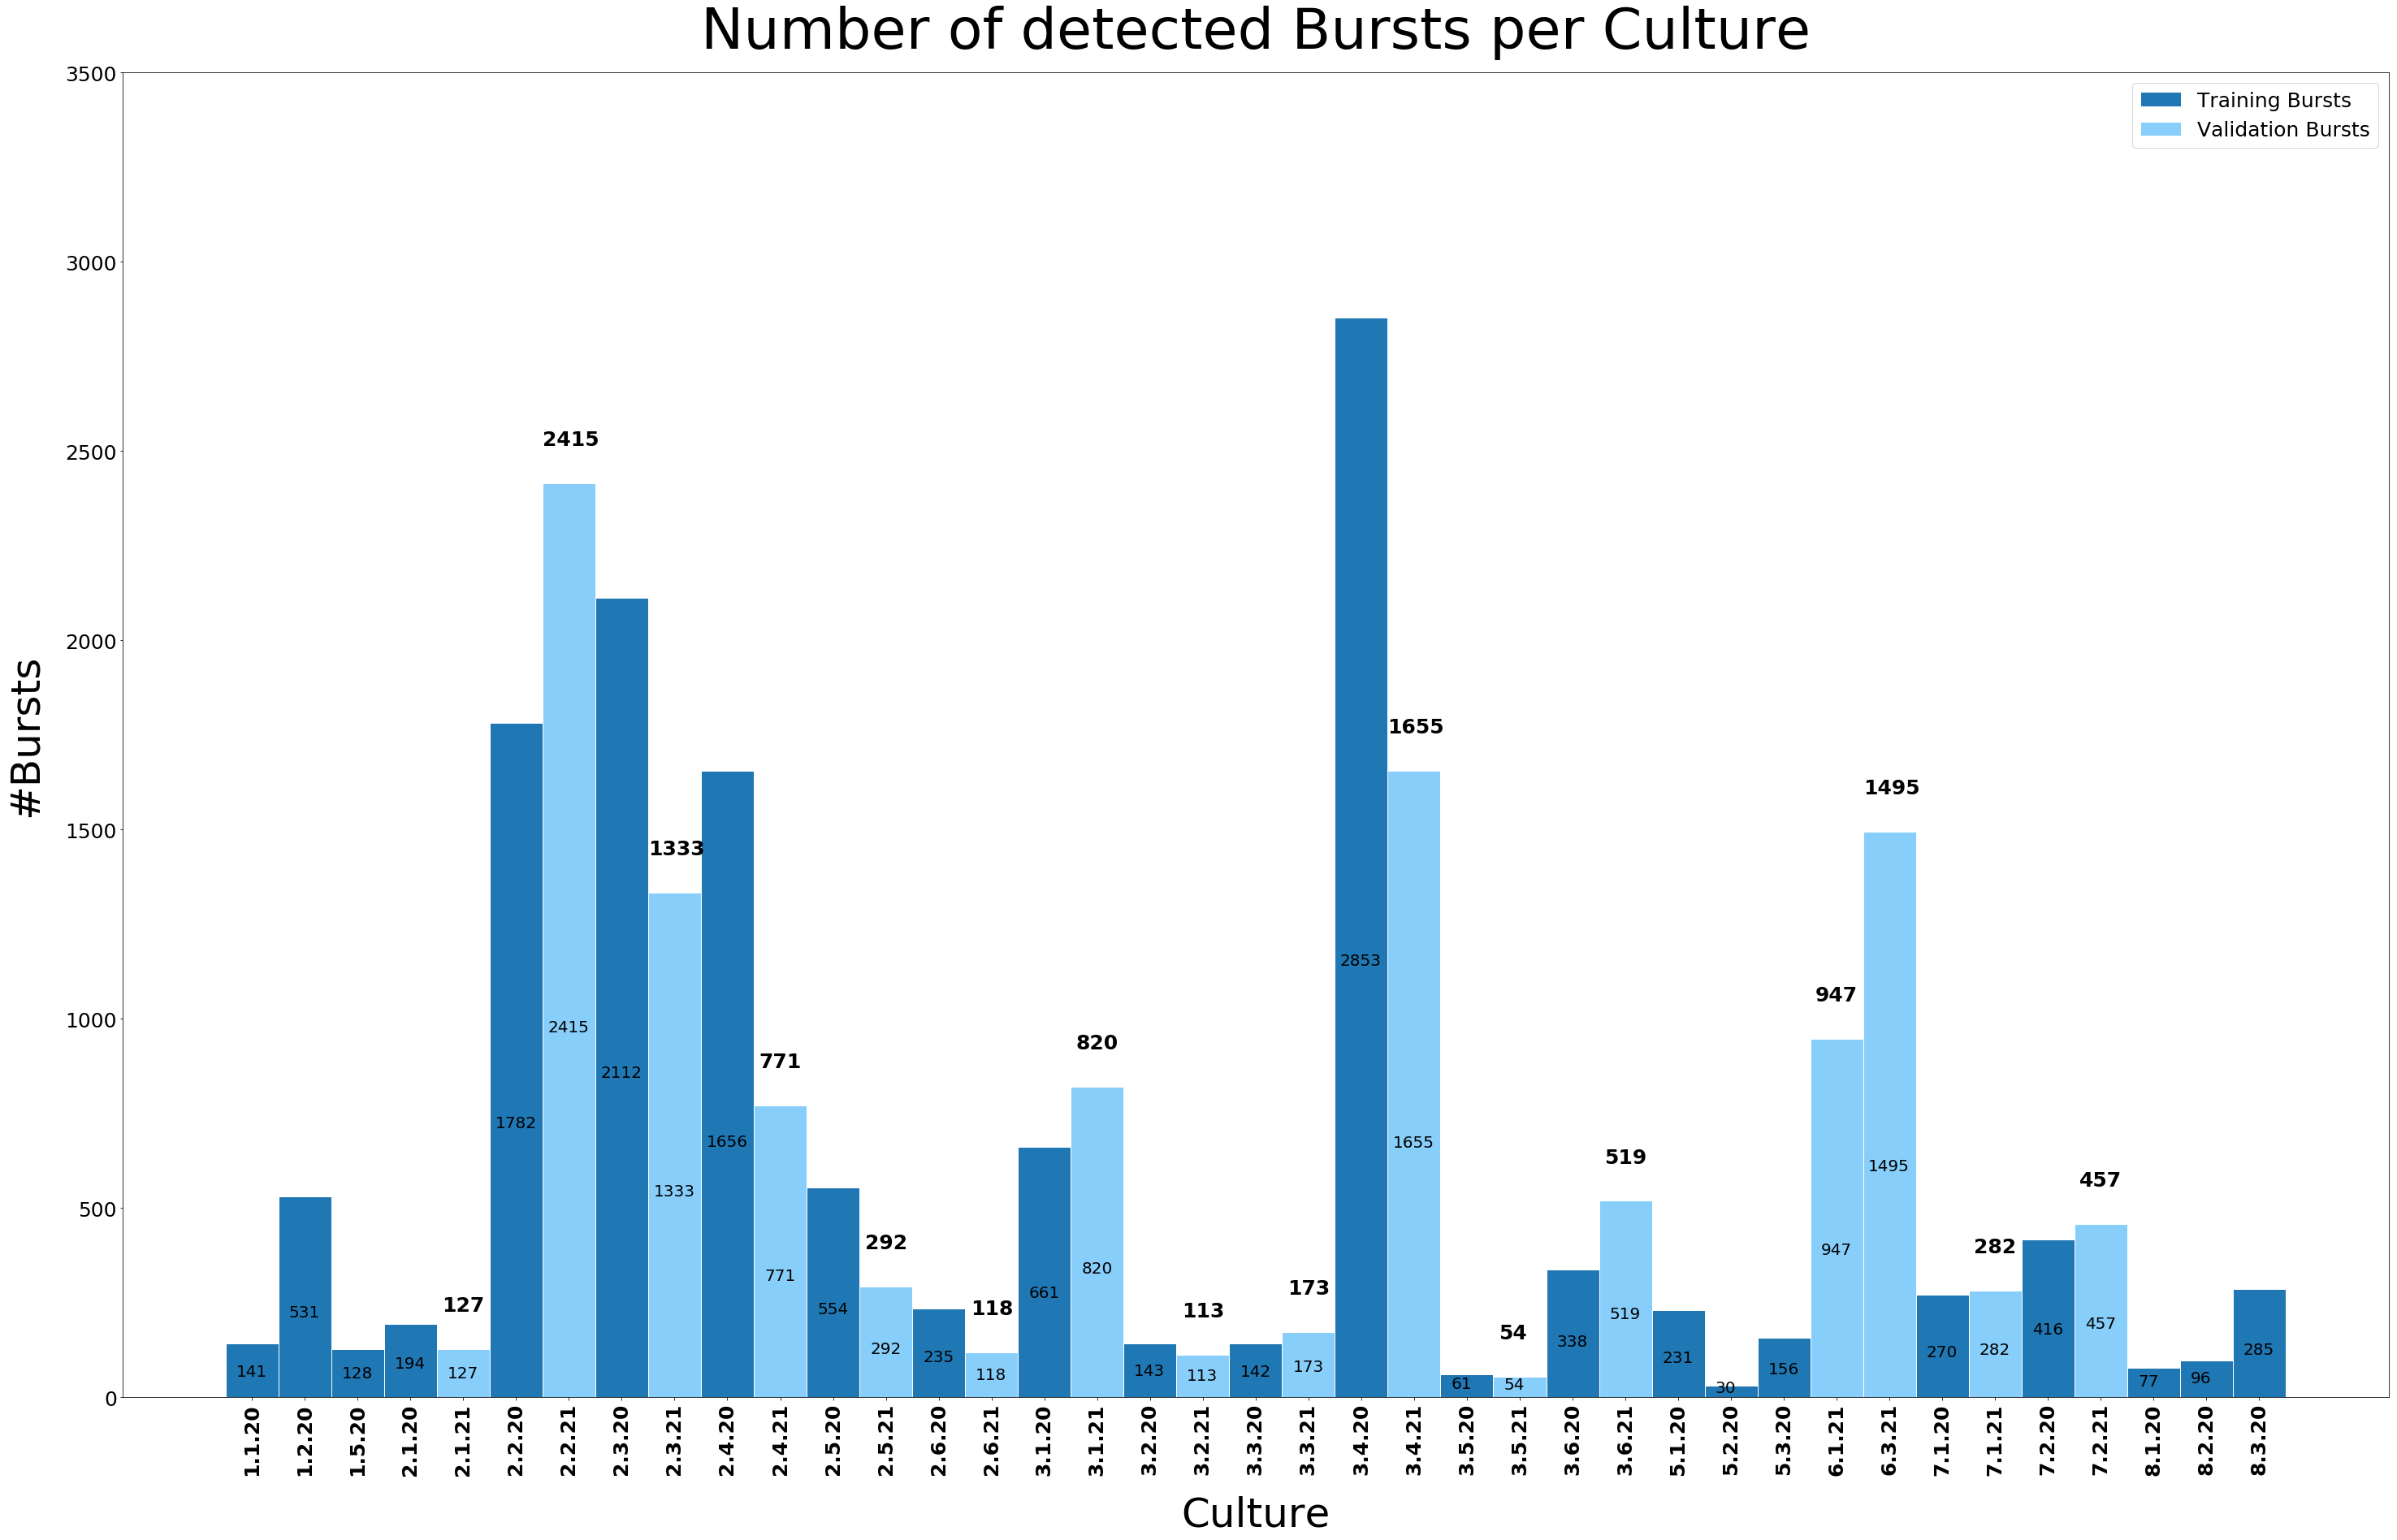

In [124]:
# The position of the bars on the x-axis
r = range(len(culture_counts.keys())) 
 
# Names of group and bar width
keys = np.sort(list(culture_counts.keys()))

names = ["sparse_" + ".".join(x.split('_')[-3:]) if x.find("Sparse")>=0 else ".".join(x.split('_')[-3:]) for x in keys]


bar_valid = [valid_culture_counts[key] for key in np.sort(list(valid_culture_counts.keys()))]
bar_train = [train_culture_counts[key] for key in np.sort(list(train_culture_counts.keys()))]

#bar = [culture_counts[key] for key in np.sort(list(culture_counts.keys()))]
barWidth = 1

fig, ax = plt.subplots(figsize=(50,30))

ax.bar(r, bar_train,edgecolor='white', width=barWidth, label = "Training Bursts")
ax.bar(r, bar_valid, bottom=bar_train, edgecolor='white',width=barWidth, label = "Validation Bursts", color ="lightskyblue")

#ax.bar(r, bar, edgecolor = 'white', width = barWidth, color = "dodgerblue")


for i,p in enumerate(ax.patches):
    if p.get_height() > 0:
        
        if len(str(p.get_height()))<= 3:
            ax.annotate(str(p.get_height()), (p.get_x()+0.2, p.get_y() + p.get_height()*0.4), fontsize = 20)
        else:
            ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_y() + p.get_height()*0.4), fontsize = 20)

        if i >= int(len(ax.patches)/2) : 
            annotation = str(culture_counts[keys[i - len(keys)]])
            if len(annotation) <= 3:
                ax.annotate(annotation, (p.get_x()+0.1, p.get_y() + p.get_height() + 100), fontsize = 25,fontweight='bold')
            else: 
                ax.annotate(annotation, (p.get_x()+0.0, p.get_y() + p.get_height() + 100), fontsize = 25,fontweight='bold')

    
# Custom X axis
ax.set_xticks(r)
ax.set_xticklabels(names,fontsize = 25, rotation='vertical', fontweight='bold')
ax.set_xlabel("Culture", fontsize = 50, labelpad=25)
ax.set_ylabel("#Bursts", fontsize = 50, labelpad=25)
ax.set_yticks(range(0,4000,500))
ax.set_yticklabels(range(0,4000,500),fontsize = 25)
ax.set_title("Number of detected Bursts per Culture",fontsize = 70,pad = 30)
# Show graphic
ax.legend(fontsize = 25)
